# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Print the data types in spotify_data
print(f'Data types:\n {spotify_data.dtypes}')

# Filter down to two genres
blues_data = spotify_data[spotify_data.genres == "blues"]
jazz_data = spotify_data[spotify_data.genres == "jazz"]

# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data], ignore_index=True)

# Rename 'genres' column to 'genre' for clarity
combined_data.rename(columns={'genres': 'genre'}, inplace=True)

Data types:
 id                   object
name                 object
album                object
album_id             object
artists              object
artist_ids           object
track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
release_date         object
genres               object
dtype: object


## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


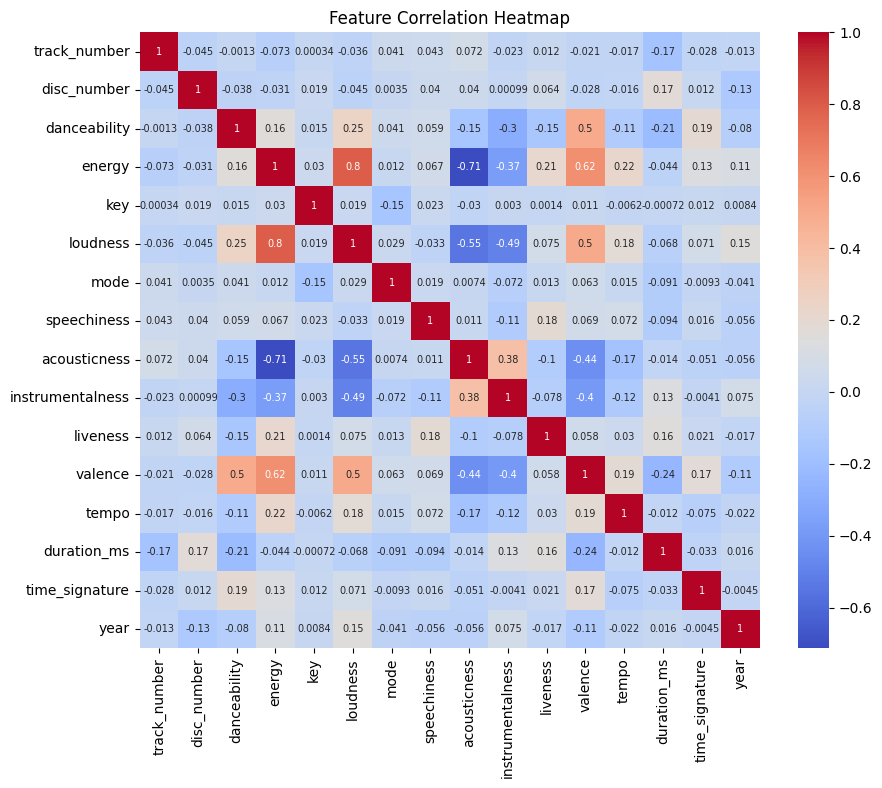

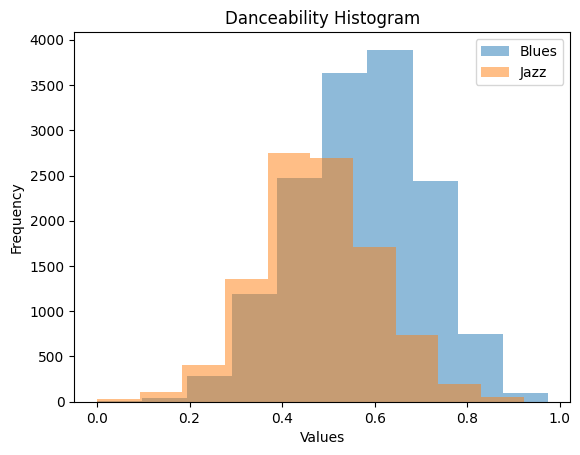

In [3]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include='number').copy()
numeric_features['genre'] = combined_data['genre']

# Correlation heatmap
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 7})
plt.title("Feature Correlation Heatmap")
plt.show()

# Histogram of danceability
plt.hist(numeric_features[numeric_features['genre'] == 'blues']['danceability'], alpha=0.5, label='Blues')
plt.hist(numeric_features[numeric_features['genre'] == 'jazz']['danceability'], alpha=0.5, label='Jazz')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Danceability Histogram')
plt.show()


### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [4]:
# Print counts of each genre
class_counts = numeric_features['genre'].value_counts()

# Calculate ratio of majority to minority class
class_ratio = class_counts[0]/class_counts[1]

# Print class distribution and ratio
print(f'Class distribution:\n {class_counts}')
print(f'Class ratio: {class_ratio:.2f}')

Class distribution:
 blues    14811
jazz     10023
Name: genre, dtype: int64
Class ratio: 1.48


Given this result, should we be worried about the imbalance?

Given the result of 1.48 (less than 1.5), I don't think we should be worried about the imbalance. 

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [5]:
# Define the features (drop columns that are not numeric or target)
X = numeric_features.drop('genre', axis = 1)

# Set the target variable as 'genre'
y = numeric_features['genre']

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
y_encoded[:5]

array([0, 0, 0, 0, 0])

Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [6]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)


### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [7]:
# Initialize models
knn = KNeighborsClassifier(n_neighbors = 5)
dt = DecisionTreeClassifier()

# Train (fit) both models
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Compute training accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

#Print training accuracy for both models
print(f"Training kNN Accuracy: {knn_train_accuracy}.")
print(f"Training DT Accuracy: {dt_train_accuracy}.")

Training kNN Accuracy: 0.9210248150198822.
Training DT Accuracy: 1.0.


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [8]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

#Print prediction accuracy for both models
print(f"Testing kNN Accuracy: {knn_accuracy}.")
print(f"Testing DT Accuracy: {dt_accuracy}.")

Testing kNN Accuracy: 0.8916851218039058.
Testing DT Accuracy: 0.8508153815180189.


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

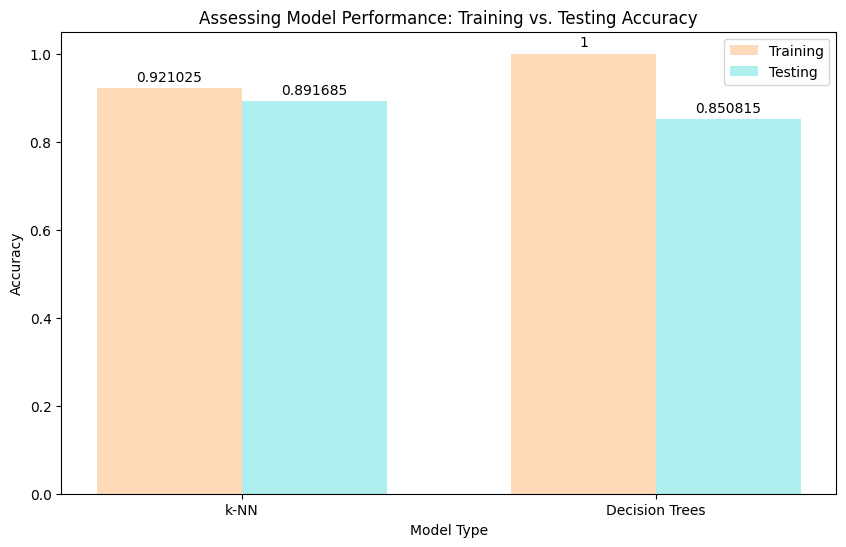

In [9]:
model = ['k-NN', 'Decision Trees']
training = [knn_train_accuracy, dt_train_accuracy]
testing = [knn_accuracy, dt_accuracy]
plot_df = pd.DataFrame({'Model': model, 'Training_Accuracy': training, 'Testing_Accuracy': testing})

# Set the figure size
plt.figure(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(plot_df['Model']))

# Plot bars for each group
bar1 = plt.bar(index, plot_df['Training_Accuracy'], bar_width, label='Training', color = "peachpuff")
bar2 = plt.bar(index + bar_width, plot_df['Testing_Accuracy'], bar_width, label='Testing', color = "paleturquoise")

# Label each bar
plt.bar_label(bar1, padding=3, fontsize=10)
plt.bar_label(bar2, padding=3, fontsize=10)

# Add axis labels and title
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Assessing Model Performance: Training vs. Testing Accuracy')
plt.xticks(index + bar_width / 2, plot_df['Model'])
plt.legend()

# Display the plot
plt.show()

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

k-NN does a better job of generalizing to unseen data, as evidenced by its higher testing accuracy score. It appears that the decision tree is overfitting because it fits the training data very well (accuracy of 1) and then fails to perform as well on the unseen testing data (accuracy of approximately 0.855). While some decrease in accuracy is expected, such a large drop, especially from a score of 1, is evidence that it is overfit to the training data.

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

In [10]:
### Optimize DT model
# Different max depths to iterate over
depth = [4, 7, 10, 13, 16, 19, 22]
accuracies = []

# Create KNN model for each value of K, fit/predict, and calculate accuracies
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train_scaled, y_train)
        
    # Make predictions and calculate accuracy
    y_pred = dt.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
        
    print(f"max_depth={d} - Accuracy: {accuracy:.3f}")

max_depth=4 - Accuracy: 0.858
max_depth=7 - Accuracy: 0.875
max_depth=10 - Accuracy: 0.875
max_depth=13 - Accuracy: 0.874
max_depth=16 - Accuracy: 0.868
max_depth=19 - Accuracy: 0.862
max_depth=22 - Accuracy: 0.853


### Bonus question

In the workflow above, we used the default parameter values of `k = 5` for the KNN model, and `maxdepth = None` for the Decision Tree.  Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.